# Определение уровня сложности фильма для изучения английского

Данный проект направлен на разработку модели, которая может автоматически определять уровень сложности англоязычных фильмов, облегчая выбор фильмов по уровню владения языком.

Входные данные состоят из набора помеченных данных с названиями фильмов, субтитрами и метками уровня владения языком (A1/A2/B1/B2/C1/C2). Из-за большого количества классов наиболее подходящей метрикой для использования будет F1-score.

### Loading and preprocessing data

In [49]:
#!pip install pysrt
#!pip install nltk
#!pip install -U spacy
#!python -m spacy download en_core_web_sm

In [50]:
#!pip install openpyxl

In [8]:
# imports
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysrt
from pickle import dump

import nltk 
from nltk.corpus import stopwords as nltk_stopwords

import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings("ignore")

In [9]:
#/Users/ktchka/Downloads/English_level/English_scores/Subtitles_all

def load_srt_from_folder(folder):
    """
    Find and load files with .srt extention in the folder.
    """
    
    root_dir = f'English_level/English_scores/Subtitles_all/{folder}/'
    subtitles, movies = [], []
    
    # find all the subtitle files with an .srt extension in root_dir
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".srt"):
                filepath = os.path.join(dirpath, filename)
                movies.append(filename[:-4]) # the movie name
                
                movie_subs = pysrt.open(filepath, encoding='iso-8859-1')
                movie_subs = [sub.text for sub in movie_subs]
                subtitles.append(' '.join(movie_subs))
    
    print(f'Subtitles: {len(subtitles)} files from {folder} loaded.')
    
    # to dataframe
    subtitles_df = pd.DataFrame({'movie': movies,
                                'text': subtitles})
    return subtitles_df

In [10]:
# load data from folders to dataframe
subs_df = pd.DataFrame(columns=['movie', 'text', 'level'])

for level in ['A2', 'B1', 'B2', 'C1']:
    part_subs_df = load_srt_from_folder(level)
    part_subs_df['level'] = level
    
    subs_df = pd.concat([subs_df, part_subs_df])   

Subtitles: 79 files from A2 loaded.
Subtitles: 80 files from B1 loaded.
Subtitles: 112 files from B2 loaded.
Subtitles: 77 files from C1 loaded.


In [11]:
subs_df.head()


,movie,text,level
0,Minions.2015.1080p.BluRay.H264.AAC-RARBG_15472...,"Subtitle created by <font color=""#ffff00"">- Ao...",A2
1,Winnie.the.Pooh.2011.720p.BrRip.X264.YIFY_1543...,Genenrated by: Team21@duasatu.com [Whistling] ...,A2
2,Turbo.2013.1080p.BluRay.H264.AAC-RARBG_1547227...,<i>And we're back at the final stretch\nof the...,A2
3,The Walking Dead-S01E03-Tell It To The Frogs.E...,( thunder rumbling ) Merle:\nThat's right. You...,A2
4,Tinker_Bell_and_the_Great_Fairy_Rescue__2010__...,<i>Some people\nsay that fairies are the stuff...,A2


In [21]:
# also the mixed data present in 'Subtitles' folder
mixed_movies = load_srt_from_folder('Subtitles')

# labels for the movies in excel file
labels = pd.read_csv(r'English_level/English_scores/movies_labels.csv', delimiter=';')
labels = labels.drop(columns='id').rename(columns={'Movie':'movie', 'Level':'level'})

# join level labels
mixed_movies = mixed_movies.merge(labels, on='movie', how='left')
mixed_movies.head()

Subtitles: 115 files from Subtitles loaded.


,movie,text,level
0,Dredd(2012),America is an irradiated wasteIand. Within it ...,A2/A2+
1,Despicable_Me(2010),"Excuse me, sir,\nis there a commode? Justin! Q...",B2
2,The_secret_life_of_Walter_Mitty(2013),"Huh? Hi! Todd Mahar,\neHarmony. How can I help...",B1
3,Shrek(2001),anoXmous\nhttps://thepiratebay.se/user/Zen_Bud...,B1
4,Deadpool(2016),<font color=#32a615><b>WordsKill</b></font>\n<...,B2


In [22]:
# duplicates
duplicated_movies = subs_df.loc[subs_df.duplicated(subset=['movie']), 'movie'].to_list()
subs_df[subs_df['movie'].isin(duplicated_movies)]

,movie,text,level


In [23]:
# join last part of movies
subs_df = pd.concat([subs_df, mixed_movies])
print(f'Amount: {subs_df.shape[0]}')

Amount: 467


In [24]:
# duplicates
duplicated_movies = subs_df.loc[subs_df.duplicated(subset=['movie']), 'movie'].to_list()
subs_df[subs_df['movie'].isin(duplicated_movies)]

,movie,text,level
25,Powder(1995),"EMT 1:\nAll right, people,\nlet's move! Let's ...",B1
26,Powder(1995),"EMT 1:\nAll right, people,\nlet's move! Let's ...",B1
37,The_terminal(2004),"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f...",B1
38,The_terminal(2004),"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f...","A2/A2+, B1"
100,The_blind_side(2009),[CROWD CHEERING IN DISTANCE] LElGH ANNE: There...,B2
101,The_blind_side(2009),[CROWD CHEERING IN DISTANCE] LElGH ANNE: There...,B1
103,Inside_out(2015),Advertise your product or brand here<br/>conta...,B1
104,Inside_out(2015),Advertise your product or brand here<br/>conta...,B1


In [25]:
subs_df = subs_df[~subs_df.duplicated(subset='movie')]
subs_df.reset_index(drop=True, inplace=True)

In [26]:
# gaps in level column
subs_df[subs_df['level'].isna()].shape[0]

9

In [27]:
# delete movies without labels
subs_df = subs_df[~subs_df['level'].isna()]

In [28]:
# unique level values
subs_df['level'].value_counts()

B2            141
B1            114
C1             83
A2             79
A2/A2+         25
B1, B2          8
A2/A2+, B1      4
Name: level, dtype: int64

Поменяем двойный лейблы - возьмем низкий уровень

In [29]:
subs_df['level'] = (subs_df['level']
                    .replace('A2/A2+', 'A2')
                    .replace('A2/A2+, B1', 'A2')
                    .replace('B1, B2', 'B1'))

In [30]:
subs_df['level'].value_counts()


B2    141
B1    122
A2    108
C1     83
Name: level, dtype: int64

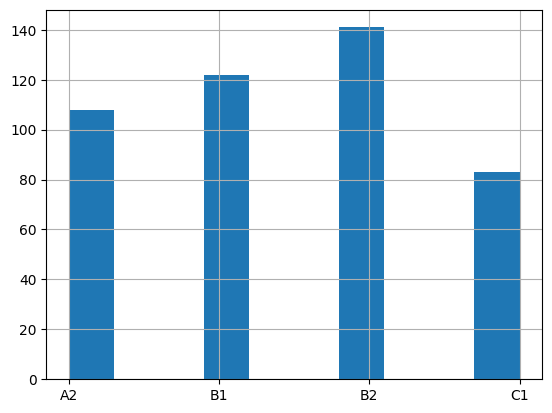

In [31]:
subs_df['level'].hist()
plt.show()

Есть дисбалланс классов, но датасет небольшой, поэтому оставим как есть

In [32]:
# example subtitle text
subs_df.loc[10, 'text']

'This is New Berk at Snoggletog,\nthe greatest time of the year. The lights, the hunting songs, the holiday shopping... - Oh!\n- Uh-huh. - Skoal!\n- Cheers! ...the yak-nog shooters. - Another round!\n- Double! The only thing missing... was dragons. It\'s been ten years since Vikings and dragons agreed to live apart, but that doesn\'t mean we\'ve forgotten our flying friends. And the best part of it all, Nuffink,\nwas on Snoggletog Eve... - Yeah.\n- I\'d make Toothless his favorite meal. - What was it?\n- Lake trout... - Yeah?\n- ...with a side of sea trout... - Yeah?\n- ...on a bed of brook trout. We all like trout! And even though he\'s gone, I still make it for him. A lot of families do stuff like this. It keeps our loved ones in our hearts,\neven though they\'re far away. So, wanna help me catch some fish? Good on you! We\'re gonna feed Toothless! I don\'t need a fishing pole, Dad. I\'ll just butt the wee fishies on their own wee head! - Ow.\n- Ah. Ow. Ow! Come on. Let\'s get Toothl

### Обработка субтитров

In [33]:
# stopwords for English from nltk
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

# additional stopwords
pronouns = ['I', 'me', 'you', 'he', 'she', 'it']
articles = ['a', 'an', 'the']
prepositions = ['in', 'on', 'at', 'by', 'to', 'for', 'from']
conjunctions = ['and', 'but', 'or', 'yet']
interjections = ['oh', 'shh', 'yeah', 'ah', 'uh', 'mmm']

stopwords = stopwords + pronouns + articles + prepositions + conjunctions + interjections


def clean_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return " ".join(text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktchka/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
# lemmatization
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    
    return lemmas

In [35]:
# regular expressions
HTML = r'<.*?>' # html tags
TAG = r'{.*?}'  # other tags
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # comments
UPPER = r'[[A-Za-z ]+[\:\]]'  # speakers names (BOBBY:)
LETTERS = r'[^a-zA-Z\'.,!? ]' # need only the letters 
APOSTROPHES = r' [A-Za-z]+\'[A-Za-z]+ ' # delete words with apostrophes
SPACES = r'([ ])\1+' # multiple spaces
SYMB = r"[^\w\d'\s]" # puctuation marks


def clean_text(text):
    """
    Clean up the text by removing unnecessary elements.
    """    
    # replace with a space
    for element in [HTML, TAG, COMMENTS, UPPER, LETTERS, APOSTROPHES]:
        text = re.sub(element, ' ', text) 
    
    # replace with an empty string
    text = re.sub(SYMB, '', text)
    text = re.sub('www', '', text)
    text = re.sub("''", '', text)
    
    # spaces
    text = re.sub(SPACES, r'\1', text)
    
    # delete non-ascii characters
    text = text.encode('ascii', 'ignore').decode() 
    
    text = text.strip() # delete left and right spaces
    text = text.lower() # lowercase

    return text

In [36]:
# general function, which includes all steps
def prepare_text(text):
    """
    - удаляет некорректные символы
    - делает лемматизацию
    - удаляет стоп-слова
    """
    text = clean_text(text)      
    text = lemmatize_text(text)  
    text = clean_stopwords(text)
    
    return text

In [37]:
%%time

subs_df['prepared_text'] = subs_df['text'].apply(prepare_text)
subs_df.loc[10, 'prepared_text'] # example

CPU times: user 7min 25s, sys: 17.3 s, total: 7min 42s
Wall time: 7min 50s


"new berk snoggletog great time year light hunt song holiday shopping huh skoal cheer yak nog shooter another round double thing miss dragon ten year since viking dragon agree live apart mean forget fly friend good part nuffink snoggletog eve make toothless favorite meal lake trout side sea trout bed brook trout like trout even though go still make lot family stuff like keep love one heart even though far away wanna help catch fish good go feed toothless need fishing pole dad butt wee fishie wee head ow ow ow come get toothless snack hey excited make traditional dragon feast hit everyone board yes work zephyr test dragon defense system grow new berk leave snack one show would great love dragon monster find attic grandpa 's come never tell truth dragon dragon wonderful friend tell giant well razor sharp tooth breathe fire suppose claw yes happen leg think maybe leave fish snack around attract 'cause know wanna dragon dessert nuffink wanna dessert dragon mm methink kill dragon happen anc

### Обучение модели

In [38]:
X = subs_df['prepared_text'] # texts
y = subs_df['level']         # target

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state = 123)

X_train.shape[0], X_test.shape[0]

(340, 114)

In [40]:
# pipeline
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=123))
])

In [46]:
params = {
    'vect__max_df': [0.75, 1.0],
    'vect__min_df': [0.01, 0.1],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__loss': ['hinge', 'log_loss'],      
    'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
    'clf__penalty': ['l2', 'elasticnet'],
    'clf__learning_rate': ['optimal', 'invscaling'],
}


grid = GridSearchCV(pipe, params, scoring='f1_macro', cv=5, n_jobs=4, verbose=1)
grid.fit(X_train, y_train)

print("Best parameters: {}".format(grid.best_params_))
print("Best score: {}".format(grid.best_score_))
print("Times info:")
display(pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')[['mean_fit_time', 'mean_score_time']])


Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters: {'clf__alpha': 0.001, 'clf__learning_rate': 'optimal', 'clf__loss': 'log_loss', 'clf__penalty': 'l2', 'vect__max_df': 1.0, 'vect__min_df': 0.01, 'vect__ngram_range': (1, 2)}
Best score: 0.6687965068654365
Times info:


,mean_fit_time,mean_score_time
85,1.298927,0.228833


In [47]:
# final testing
pipe_final = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, min_df=0.01, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log', 
                          alpha=0.001, 
                          penalty='l2', 
                          learning_rate='optimal',
                          random_state=123))
])

pipe_final.fit(X_train, y_train)
predictions = pipe_final.predict(X_test)
f1 = f1_score(y_test, predictions, average='macro')
print(f'F1 score for test set: {round(f1, 3)}')


F1 score for test set: 0.639


In [48]:
# export model to file
with open('sgd_model.pcl', 'wb') as fid:
    dump(pipe_final, fid)

## Вывод

Целью данного проекта была разработка модели для определения уровня сложности англоязычных фильмов. Был выбран алгоритм SGDClassifier. Наилучший f1_score - 0,632.

Для достижения этого результата текстовые данные были сначала предварительно обработаны путем удаления ненужных фрагментов и стоп-слов, лемматизации слов, а также преобразования текста в числовые характеристики с помощью CountVectorizer и TfidfTransformer. Затем был использован алгоритм SGDClassifier с GridSearchCV для оптимизации гиперпараметров.
